# Đọc file excel, merge các cột vào 1 bảng chung

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
data = pd.read_excel('CuoiKy.xlsm')
DataMaster = pd.read_excel('CuoiKy.xlsm', sheet_name = 'Data_Master')
CustomerMaster = pd.read_excel('CuoiKy.xlsm', sheet_name = 'Customer_Master')
ProductMaster = DataMaster.iloc[0:37, 0:17]
ProductMaster = ProductMaster.rename(columns=ProductMaster.iloc[0])
ProductMaster = ProductMaster[1:]
SalesOrder = pd.read_excel('CuoiKy.xlsm', sheet_name = 'Sales_Order')

PackagingMaster = DataMaster.iloc[39:50, 0:5]
PackagingMaster = PackagingMaster.rename(columns=PackagingMaster.iloc[0])
PackagingMaster = PackagingMaster.fillna(method='ffill')

FacilityMaster = DataMaster.iloc[52:59, 0:11]
FacilityMaster = FacilityMaster.rename(columns=FacilityMaster.iloc[0])
FacilityMaster = FacilityMaster[1:]

CollectionPointCapacity = DataMaster.iloc[61:65, 0:6]
CollectionPointCapacity = CollectionPointCapacity.rename(columns=CollectionPointCapacity.iloc[0])
CollectionPointCapacity = CollectionPointCapacity[1:]
CollectionPointCapacity = CollectionPointCapacity.fillna(method='ffill')
SalesOrder = SalesOrder.iloc[:, :16]
MyData = pd.DataFrame()
MyData['ProductID'] = SalesOrder['ProductID']
MyData['CustomerRef'] = SalesOrder['CustomerRef']
MyData['SOCreationDate'] = SalesOrder['SOCreationDate']
MyData['DispatchQuantityInKg'] = SalesOrder['DispatchQuantityInKg']
MyData['NetWeightInKg'] = SalesOrder['NetWeightInKg']
MyData['GrossWeightInKg'] =SalesOrder['GrossWeightInKg']

# Merge the ProductMaster DataFrame with MyData DataFrame based on 'ProductID'
MyData = MyData.merge(ProductMaster[['ProductID', 'ProductName', 'ShelfLifeInDays', 'KgPerPallet', 'Unit', 'CartonsPerPallet', 'UnitperCarton']], on='ProductID', how='left')

# Merge the CustomerMaster DataFrame with MyData DataFrame based on 'CustomerRef'
MyData = MyData.merge(CustomerMaster[['CustomerRef', 'Longitude', 'Latitude']], on='CustomerRef', how='left')
#Calculate number of pallet per bill
MyData['NumberOfPallet'] = MyData['NetWeightInKg']/ MyData['KgPerPallet']
#Calculate number of unit
MyData['NumberOfUnit'] = MyData['NumberOfPallet'] * MyData['CartonsPerPallet'] * MyData['UnitperCarton'].astype(float)
MyData.head()

C:\Users\DELL\anaconda3\lib\site-packages\openpyxl\worksheet\_read_only.py:79: UserWarning: Unknown extension is not supported and will be removed
  for idx, row in parser.parse():
C:\Users\DELL\anaconda3\lib\site-packages\openpyxl\worksheet\_read_only.py:79: UserWarning: Unknown extension is not supported and will be removed
  for idx, row in parser.parse():


,ProductID,CustomerRef,SOCreationDate,DispatchQuantityInKg,NetWeightInKg,GrossWeightInKg,ProductName,ShelfLifeInDays,KgPerPallet,Unit,CartonsPerPallet,UnitperCarton,Longitude,Latitude,NumberOfPallet,NumberOfUnit
0,3110685,14019842,2021-08-02,57224.8944,57224.8944,58697.5260,OW MLK WHOLE 6X2L BOT,19,991.68,GBOT,80.0,6,144.763895,-37.831035,57.705,27698.4
1,3110678,14019842,2021-08-02,77232.0384,77232.0384,79387.7568,OW MLK WHOLE 4x3L BOT,19,991.68,GBOT,80.0,4,144.763895,-37.831035,77.88,24921.6
2,3103449,14019842,2021-08-02,13387.6800,13387.6800,13732.2000,OW FRMRS OWN MLK FL CRM 6X2L BOT,19,991.68,GBOT,80.0,6,144.763895,-37.831035,13.5,6480.0
3,3103450,14019842,2021-08-02,2380.0320,2380.0320,2446.4640,OW FRMRS OWN MLK FL CRM 4X3L BOT,19,991.68,GBOT,80.0,4,144.763895,-37.831035,2.4,768.0
4,3110656,11002626,2021-08-02,7147.0080,7147.0080,7330.7520,OW MLK LITE 6X2L BOT,19,992.64,GBOT,80,6,146.721094,-36.076072,7.2,3456.0


# Tính tổng pallet cho từng khách hàng

In [9]:
CalculateProductGrouped = MyData.groupby('CustomerRef')
PalletPerCustomerRef = CalculateProductGrouped['NumberOfPallet'].sum()
PalletPerCustomerRef = PalletPerCustomerRef.reset_index()
PalletPerCustomerRef.head()

,CustomerRef,NumberOfPallet
0,11000128,92.99
1,11000144,7.470929
2,11000149,6.678
3,11000159,0.342
4,11000176,3.466706


# Tính khoảng cách từ DC (distribution center) tới từng khách hàng

In [10]:
PalletPerCustomerRef = PalletPerCustomerRef.merge(CustomerMaster[['CustomerRef', 'Longitude', 'Latitude']],
                                                  on='CustomerRef', how='left')
DC_facilities = FacilityMaster[FacilityMaster['Type'] == 'DC']
DC_Longitude = DC_facilities['Longitude'].mean()
DC_Latitude = DC_facilities['Latitude'].mean()
import math
PalletPerCustomerRef['DistanceToDC'] = (PalletPerCustomerRef['Latitude'] - DC_Latitude)**2 + (PalletPerCustomerRef['Longitude'] - DC_Longitude)**2
PalletPerCustomerRef['DistanceToDC'] = PalletPerCustomerRef['DistanceToDC'].apply(lambda x: math.sqrt(x))
PalletPerCustomerRef.head()

,CustomerRef,NumberOfPallet,Longitude,Latitude,DistanceToDC
0,11000128,92.99,145.206237,-38.025962,0.488578
1,11000144,7.470929,144.947676,-37.728991,0.192579
2,11000149,6.678,152.519049,-32.197687,9.564369
3,11000159,0.342,153.122555,-27.617230,13.173460
4,11000176,3.466706,145.197119,-37.990926,0.465374


# Tiến hành phân cụm

C:\Users\DELL\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\DELL\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
C:\Users\DELL\AppData\Local\Temp\ipykernel_12396\701393256.py:24: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color_map = plt.cm.get_cmap('Set1', len(np.unique(labels)))


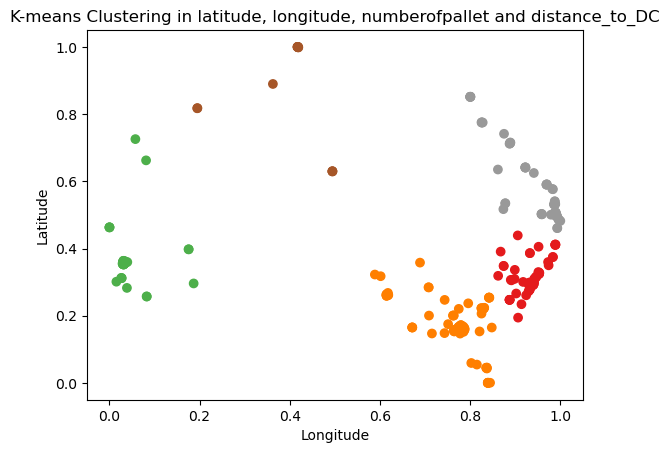

In [115]:
from sklearn.preprocessing import MinMaxScaler
# Các cột xác định cần chuẩn hóa
columns_to_normalize = ['Latitude', 'Longitude', 'DistanceToDC', 'NumberOfPallet']
scaler = MinMaxScaler()
df_normalized = PalletPerCustomerRef.copy()
df_normalized[columns_to_normalize] = scaler.fit_transform(PalletPerCustomerRef[columns_to_normalize])

from sklearn.cluster import KMeans
# Dữ liệu vĩ độ và kinh độ
Longitude = df_normalized['Longitude']
Latitude = df_normalized['Latitude']
NumberOfPallet = df_normalized['NumberOfPallet']
DistanceToDC = df_normalized['DistanceToDC']
# Ghép hai features thành một mảng 2D
data = np.column_stack((Latitude, Longitude, DistanceToDC, NumberOfPallet))

# Áp dụng KMeans với số lượng cụm mong muốn
kmeans = KMeans(n_clusters=5)
kmeans.fit(data)
# Lấy nhãn của các điểm dữ liệu
labels = kmeans.labels_

# Tạo bảng màu cho các nhãn
color_map = plt.cm.get_cmap('Set1', len(np.unique(labels)))

# Vẽ biểu đồ
# Lấy giá trị trung tâm của từng cụm
cluster_centers = kmeans.cluster_centers_
# Vẽ biểu đồ các trung tâm cụm
plt.scatter(data[:, 1], data[:, 0], c=labels, cmap=color_map)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('K-means Clustering in latitude, longitude, numberofpallet and distance_to_DC')
plt.show()

#  Tính toán chi phí, dung tích cho từng cụm

In [12]:
PalletPerCustomerRef['Cluster'] = labels
MyData = MyData.merge(PalletPerCustomerRef[['CustomerRef', 'Cluster']], on='CustomerRef', how='left')
dfCapacity = MyData.loc[:, ['SOCreationDate', 'NumberOfPallet', 'Cluster']]
# Gom nhóm theo cụm và theo các tuần
CapacityGrouped = dfCapacity.groupby(['Cluster', 'SOCreationDate'])
dfCapacityGrouped = CapacityGrouped['NumberOfPallet'].sum().reset_index()
dfCapacityGrouped = dfCapacityGrouped[dfCapacityGrouped['SOCreationDate'].dt.year == 2022].reset_index(drop=True)
dfCapacityGrouped['Week'] = dfCapacityGrouped['SOCreationDate'].dt.isocalendar().week
dfCapacityGrouped['NumberOfPalletReturned'] = dfCapacityGrouped['NumberOfPallet'] / 2

dfCapacityGrouped.head()

,Cluster,SOCreationDate,NumberOfPallet,Week,NumberOfPalletReturned
0,0,2022-01-04,20.477353,1,10.238677
1,0,2022-01-05,4.9815,1,2.49075
2,0,2022-01-06,3.594286,1,1.797143
3,0,2022-01-07,15.195,1,7.5975
4,0,2022-01-08,0.72,1,0.36


## Tạo dataframe cho từng cụm

In [14]:
cluster_data = {}

for cluster in dfCapacityGrouped['Cluster'].unique():
    cluster_data[cluster] = dfCapacityGrouped[dfCapacityGrouped['Cluster'] == cluster].reset_index()

## Hàm tính chi phí

In [13]:
def costOverFlowPerWeek(numberOfWeek, Size, df):
    size = Size
    sumPallet = 0
    dateOverflow = 0
    totalCostOverFlowPerWeek = 0
    initOverflow = 0
    for i in range(df.shape[0]):
        if df['Week'][i] == numberOfWeek:
            if sumPallet < size:
                sumPallet += df['NumberOfPalletReturned'][i]
                if sumPallet > size:
                    dateOverflow = (df['SOCreationDate'][i].weekday() + 1)
                    initOverflow = (sumPallet - size) * 3
                    sumPallet = size
            else:
                sumPallet += df['NumberOfPalletReturned'][i]
    if sumPallet - size > 0:
        totalCostOverFlowPerWeek = initOverflow + (sumPallet - size) * 3 * (7 - dateOverflow)
        return totalCostOverFlowPerWeek
    else:
        return 0

def costOverflow(df, Size):
    cost = 0
    for week in range(1, 53):
        cost += costOverFlowPerWeek(week, Size, df)
    return cost   

def totalCost(df, Size):
    return Size * 100 + costOverflow(df, Size)

## Xác định size từng cụm sao cho tổng chi phí (hằng năm và overflow) là thấp nhất

In [15]:
sizeCluster = []
for cluster in range(5):
    costList = []
    sizeList = list(range(1, 51, 1))
    for size in sizeList:
        costList.append(totalCost(cluster_data[cluster], size))
    sizeCluster.append(sizeList[costList.index(min(costList))])
sizeCluster

[40, 20, 29, 50, 3]

In [16]:
costList = []
sizeList = list(range(1000, 1501, 10))
for size in sizeList:
    costList.append(totalCost(cluster_data[3], size))
sizeCluster.append(sizeList[costList.index(min(costList))])

In [18]:
sizeCluster = [40, 20, 29, 1330, 3]

Chọn size 70 (small) cho các cụm 0, 1, 2 và 4. 

Chọn 6 điểm thu gom size small và 4 điểm thu gom size medium cho cụm 3

In [116]:
print("Total cost:")
print("Cluster 0:", totalCost(cluster_data[0], 70))
print("Cluster 1:", totalCost(cluster_data[1], 70))
print("Cluster 2:", totalCost(cluster_data[2], 70))
print("Cluster 3:", totalCost(cluster_data[3], 1340))
print("Cluster 4:", totalCost(cluster_data[4], 70))
print("Total:", totalCost(cluster_data[0], 70) + totalCost(cluster_data[1], 70) + totalCost(cluster_data[2], 70) + totalCost(cluster_data[4], 70) + totalCost(cluster_data[3], 1340))

Total cost:
Cluster 0: 7000
Cluster 1: 7000
Cluster 2: 7000
Cluster 3: 142211.41162977455
Cluster 4: 7000
Total: 170211.41162977455


# GHG

In [99]:
MyData['PackagingWeightInKg'] = MyData['GrossWeightInKg'] - MyData['NetWeightInKg']
MyData = MyData[MyData['SOCreationDate'].dt.year == 2022].reset_index(drop=True)
PackageGrouped = MyData.groupby('Unit')
dfPackageGrouped =PackageGrouped['PackagingWeightInKg'].sum()
dfPackageGrouped = dfPackageGrouped.reset_index()
dfPackageGrouped['PackagingWeightReturned'] = dfPackageGrouped['PackagingWeightInKg']/2
CircularInflow = []
value = 0.0
while value < 1.01:
    CircularInflow.append(value)
    value += 0.01
CircularInflow = [round(value, 2) for value in CircularInflow]
CO2_cause_by_collection_point = MyData['NumberOfPallet'].sum()/2 * 2.4 * 0.371 /365 * 1000
CO2_cause_by_collection_point


181471.7713283413

## Tổng khí thải 2022 nếu chưa thực hiện tái chế

In [101]:
CO2= dfPackageGrouped.iloc[0, 1]*0.7 + dfPackageGrouped.iloc[1, 1]*1.2 + dfPackageGrouped.iloc[2, 1] * 3.1
CO2

5747287.670759997

## Tổng khí thải 2022 nếu được thực hiện tái chế

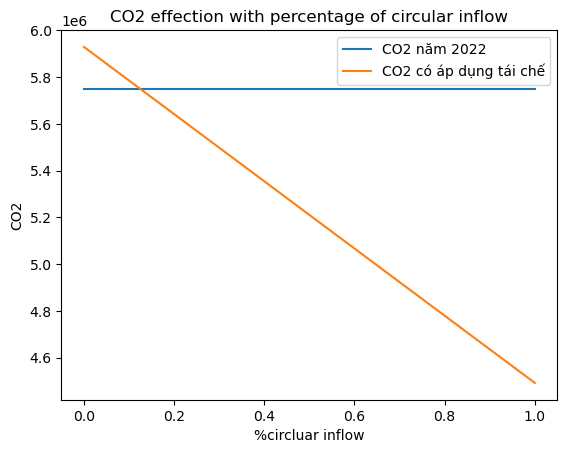

In [102]:
CO2_Cause_By_Reduced_Material = []
CO2_Cause_By_Virgin_Material = []
for inflow in CircularInflow:
    result1 = dfPackageGrouped.iloc[0, 2] * inflow * 0.57 + dfPackageGrouped.iloc[1, 2] * inflow * 0.55 + dfPackageGrouped.iloc[2, 2] * inflow * 1.7
    result2 = (dfPackageGrouped.iloc[0, 1] - dfPackageGrouped.iloc[0, 2] * inflow) * 0.7 + (dfPackageGrouped.iloc[1, 1] - dfPackageGrouped.iloc[1, 2] * inflow) * 1.2 + (dfPackageGrouped.iloc[2, 1] - dfPackageGrouped.iloc[2, 2] * inflow)*3.1
    CO2_Cause_By_Reduced_Material.append(result1)
    CO2_Cause_By_Virgin_Material.append(result2)
total_CO2 = []
for i in range(len(CO2_Cause_By_Reduced_Material)):
    total_CO2.append(CO2_Cause_By_Reduced_Material[i] + CO2_Cause_By_Virgin_Material[i] + CO2_cause_by_collection_point)

# biểu đồ
plt.ylabel('CO2')
plt.xlabel('%circluar inflow')
plt.title('CO2 effection with percentage of circular inflow')
# Tạo dữ liệu điểm trên đường ngang
x = np.linspace(0, 1, 100)
y = np.ones_like(x) * CO2

# Vẽ đường ngang
plt.plot(x, y, label='CO2 năm 2022')
plt.plot(CircularInflow, total_CO2, label = 'CO2 có áp dụng tái chế')
# Chú thích cho đường ngang
plt.legend()

Dựa vào biểu đồ --> đề xuất % circular inflow là 100%

In [104]:
print("GHG saved: ", CO2 - total_CO2[100])

GHG saved:  1255182.3958716579


# Tổng số bao bì được tái sử dụng

In [33]:
print("Total CTN recycled: ", dfPackageGrouped.iloc[0, 1])
print("Total GBOT recycled: ", dfPackageGrouped.iloc[1, 1])
print("Total PBOT recycled: ", dfPackageGrouped.iloc[2, 1])

Total CTN recycled:  515604.6479999996
Total GBOT recycled:  3458379.0431999983
Total PBOT recycled:  398809.5372000001


Hết

# Cải thiện cách phân cụm

# Thực hiện gộp các cụm nhỏ để giảm chi phí thuê hằng năm

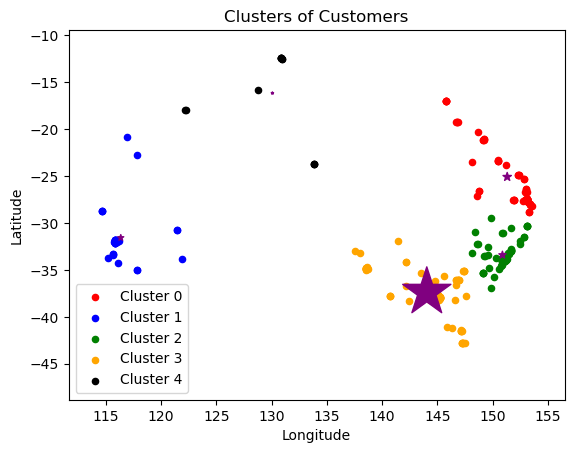

In [35]:
restored_data = scaler.inverse_transform(cluster_centers)
restored_data
# Cụm 0
Longitude_0 = PalletPerCustomerRef[PalletPerCustomerRef['Cluster'] == 0]['Longitude']
Latitude_0 = PalletPerCustomerRef[PalletPerCustomerRef['Cluster'] == 0]['Latitude']
plt.scatter(Longitude_0, Latitude_0, s=20, c='red', label='Cluster 0')

# Cụm 1
Longitude_1 = PalletPerCustomerRef[PalletPerCustomerRef['Cluster'] == 1]['Longitude']
Latitude_1 = PalletPerCustomerRef[PalletPerCustomerRef['Cluster'] == 1]['Latitude']
plt.scatter(Longitude_1, Latitude_1, s=20, c='blue', label='Cluster 1')

# Cụm 2
Longitude_2 = PalletPerCustomerRef[PalletPerCustomerRef['Cluster'] == 2]['Longitude']
Latitude_2 = PalletPerCustomerRef[PalletPerCustomerRef['Cluster'] == 2]['Latitude']
plt.scatter(Longitude_2, Latitude_2, s=20, c='green', label='Cluster 2')

# Cụm 3
Longitude_3 = PalletPerCustomerRef[PalletPerCustomerRef['Cluster'] == 3]['Longitude']
Latitude_3 = PalletPerCustomerRef[PalletPerCustomerRef['Cluster'] == 3]['Latitude']
plt.scatter(Longitude_3, Latitude_3, s=20, c='orange', label='Cluster 3')

# Cụm 4
Longitude_4 = PalletPerCustomerRef[PalletPerCustomerRef['Cluster'] == 4]['Longitude']
Latitude_4 = PalletPerCustomerRef[PalletPerCustomerRef['Cluster'] == 4]['Latitude']
plt.scatter(Longitude_4, Latitude_4, s=20, c='black', label='Cluster 4')
# Đặt giới hạn cho trục x và y
plt.xlim(CustomerMaster['Longitude'].min() - 3, CustomerMaster['Longitude'].max()+ 3) 
plt.ylim(CustomerMaster['Latitude'].min() - 6, CustomerMaster['Latitude'].max()+ 3) 
plt.scatter(restored_data[:, 1], restored_data[:, 0], s=sizeCluster, marker='*', color='purple')

# Đặt tiêu đề và chú thích
plt.title('Clusters of Customers')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend()

# Hiển thị biểu đồ chung
plt.show()

In [36]:
cluster_0_and_2 = PalletPerCustomerRef[(PalletPerCustomerRef['Cluster'] == 0) | (PalletPerCustomerRef['Cluster'] == 2)]
cluster_1_and_4 = PalletPerCustomerRef[(PalletPerCustomerRef['Cluster'] == 1) | (PalletPerCustomerRef['Cluster'] == 4)]

## Xác định lại vị trí đặt điểm thu gom

In [38]:
# Các cột xác định cần chuẩn hóa
columns_to_normalize = ['DistanceToDC', 'NumberOfPallet']
scaler = MinMaxScaler()
df_normalized_cluster_0_and_2 = cluster_0_and_2.copy()
df_normalized_cluster_0_and_2[columns_to_normalize] = scaler.fit_transform(cluster_0_and_2[columns_to_normalize])
df_normalized_cluster_1_and_4 = cluster_1_and_4.copy()
df_normalized_cluster_1_and_4[columns_to_normalize] = scaler.fit_transform(cluster_1_and_4[columns_to_normalize])
# Dữ liệu vĩ độ và kinh độ
Longitude = df_normalized_cluster_0_and_2['Longitude']
Latitude = df_normalized_cluster_0_and_2['Latitude']
NumberOfPallet = df_normalized_cluster_0_and_2['NumberOfPallet']
DistanceToDC = df_normalized_cluster_0_and_2['DistanceToDC']
# Ghép hai features thành một mảng 2D
data = np.column_stack((Latitude, Longitude, NumberOfPallet, DistanceToDC))

# Áp dụng KMeans với số lượng cụm mong muốn
kmeans = KMeans(n_clusters=1)
kmeans.fit(data)
# Lấy giá trị trung tâm của từng cụm
cluster_centers = kmeans.cluster_centers_
longitude_cluster_0_and_2_center = cluster_centers[0 ,1]
latitude_cluster_0_and_2_center = cluster_centers[0, 0]

C:\Users\DELL\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\DELL\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


In [39]:
# Dữ liệu vĩ độ và kinh độ
Longitude = df_normalized_cluster_1_and_4['Longitude']
Latitude = df_normalized_cluster_1_and_4['Latitude']
NumberOfPallet = df_normalized_cluster_1_and_4['NumberOfPallet']
DistanceToDC = df_normalized_cluster_1_and_4['DistanceToDC']
# Ghép hai features thành một mảng 2D
data = np.column_stack((Latitude, Longitude, NumberOfPallet, DistanceToDC))

# Áp dụng KMeans với số lượng cụm mong muốn
kmeans = KMeans(n_clusters=1)
kmeans.fit(data)
# Lấy giá trị trung tâm của từng cụm
cluster_centers = kmeans.cluster_centers_
longitude_cluster_1_and_4_center = cluster_centers[0 ,1]
latitude_cluster_1_and_4_center = cluster_centers[0, 0]

C:\Users\DELL\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\DELL\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


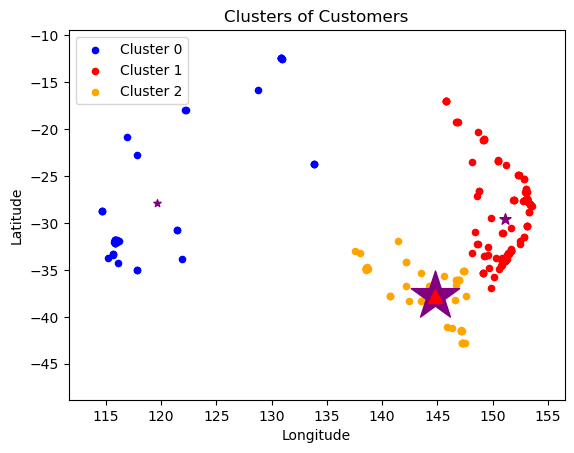

In [122]:
# Cụm 1 và cụm 4
Longitude_0 = PalletPerCustomerRef[(PalletPerCustomerRef['Cluster'] == 1) | (PalletPerCustomerRef['Cluster'] == 4)]['Longitude']
Latitude_0 = PalletPerCustomerRef[(PalletPerCustomerRef['Cluster'] == 1) | (PalletPerCustomerRef['Cluster'] == 4)]['Latitude']
plt.scatter(Longitude_0, Latitude_0, s=20, c='blue', label='Cluster 0')

# Cụm 0 và cụm 2
Longitude_1 = PalletPerCustomerRef[(PalletPerCustomerRef['Cluster'] == 0) | (PalletPerCustomerRef['Cluster'] == 2)]['Longitude']
Latitude_1 = PalletPerCustomerRef[(PalletPerCustomerRef['Cluster'] == 0) | (PalletPerCustomerRef['Cluster'] == 2)]['Latitude']
plt.scatter(Longitude_1, Latitude_1, s=20, c='red', label='Cluster 1')

# Cụm 3
Longitude_3 = PalletPerCustomerRef[PalletPerCustomerRef['Cluster'] == 3]['Longitude']
Latitude_3 = PalletPerCustomerRef[PalletPerCustomerRef['Cluster'] == 3]['Latitude']
plt.scatter(Longitude_3, Latitude_3, s=20, c='orange', label='Cluster 2')

# Đặt giới hạn cho trục x và y
plt.xlim(CustomerMaster['Longitude'].min() - 3, CustomerMaster['Longitude'].max() + 3)
plt.ylim(CustomerMaster['Latitude'].min() - 6, CustomerMaster['Latitude'].max() + 3)

# Plot cluster centers
plt.scatter(longitude_cluster_1_and_4_center, latitude_cluster_1_and_4_center, s=30, marker='*', color='purple')
plt.scatter(longitude_cluster_0_and_2_center, latitude_cluster_0_and_2_center, s=70, marker='*', color='purple')
plt.scatter(DC_Longitude, DC_Latitude, s=1340, marker='*', color='purple')
plt.scatter(DC_Longitude, DC_Latitude, s = 100, marker = '^', color = 'red')
# Đặt tiêu đề và chú thích
plt.title('Clusters of Customers')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend()
# Hiển thị biểu đồ chung
plt.show()

## Xác định size từng cụm sao cho tổng chi phí (hằng năm và overflow) là thấp nhất

In [62]:
cluster_again = {}
cluster_again[0] = pd.concat([dfCapacityGrouped[dfCapacityGrouped['Cluster'] == 0], dfCapacityGrouped[dfCapacityGrouped['Cluster'] == 2]])
cluster_again[1] = pd.concat([dfCapacityGrouped[dfCapacityGrouped['Cluster'] == 1], dfCapacityGrouped[dfCapacityGrouped['Cluster'] == 4]])
cluster_again[2] = dfCapacityGrouped[dfCapacityGrouped['Cluster'] == 3]
cluster_again[0] = cluster_again[0].reset_index()
cluster_again[1] = cluster_again[1].reset_index()
cluster_again[2] = cluster_again[2].reset_index()
cluster_again[2].head()

,index,Cluster,SOCreationDate,NumberOfPallet,Week,NumberOfPalletReturned
0,752,3,2022-01-01,152.4,52,76.2
1,753,3,2022-01-03,73.2,1,36.6
2,754,3,2022-01-04,605.263833,1,302.631917
3,755,3,2022-01-05,389.689706,1,194.844853
4,756,3,2022-01-06,439.279676,1,219.639838


In [61]:
sizeClusterAgain = []

for cluster in range(2):
    costList = []
    sizeList = list(range(40, 120, 10))
    for size in sizeList:
        costList.append(totalCost(cluster_again[cluster], size))
    sizeClusterAgain.append(sizeList[costList.index(min(costList))])
sizeClusterAgain.append(1330)

In [121]:
print("Total cost: ")
print("Cluster 0:", totalCost(cluster_again[0], 70))
print("Cluster 1:", totalCost(cluster_again[1], 70))
print("Cluster 2:", totalCost(cluster_again[2], 1340))
print("Total:", totalCost(cluster_again[0], 70) + totalCost(cluster_again[1], 70) + totalCost(cluster_again[2], 1340))

Total cost: 
Cluster 0: 8762.317979567999
Cluster 1: 7000
Cluster 2: 142211.41162977455
Total: 157973.72960934255


Giảm được khoảng 13000$ so với phương án ban đầu

Lượng GHG gây ra từ số lượng sản phẩm bán được nên các cách phân cụm khác nhau không gây ảnh hưởng đến lượng khí thải nhà kính. 

--> lượng khí thải nhà kính trong trường hợp này bằng với trường hợp trước

In [113]:
print("GHG saved: ", CO2 - total_CO2[100], " (CO2-eq)")
print("Total CO2: ", total_CO2[100], " (CO2-eq)")
print("Total CTN recycled: ", dfPackageGrouped.iloc[0, 2], " (kg)")
print("Total GBOT recycled: ", dfPackageGrouped.iloc[1, 2], " (kg)")
print("Total PBOT recycled: ", dfPackageGrouped.iloc[2, 2], " (kg)")

GHG saved:  1255182.3958716579  (CO2-eq)
Total CO2:  4492105.274888339  (CO2-eq)
Total CTN recycled:  257802.3239999998  (kg)
Total GBOT recycled:  1729189.5215999992  (kg)
Total PBOT recycled:  199404.76860000004  (kg)


In [118]:
print("Features:")
print("1. Latitude")
print("2. Longitude")
print("3. Number of pallet")
print('4. Distance to Distribution Center')

Features:
1. Latitude
2. Longitude
3. Number of pallet
4. Distance to Distribution Center
